In [1]:
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris


@dataclass
class AdalineGD:
    eta: float = 0.01
    n_iter: int = 50
    random_state: int = 1

    w_: list[float] = field(default_factory=list)
    cost_: list[float] = field(default_factory=list)

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)
X = X.values[:100, [2, 3]]  # Select only petal length and petal width
y = y.values[:100]
y = np.where(y == 0, 1, -1)
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

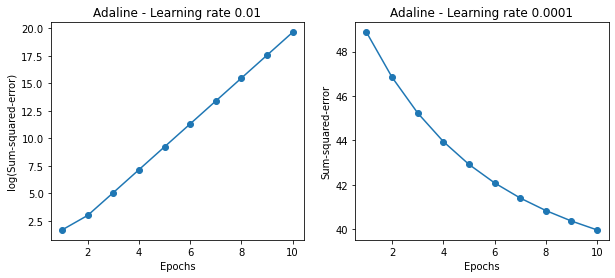

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

etas = [0.01, 0.0001]
error_fns = [np.log10, lambda x: x]
y_labels = ["log(Sum-squared-error)", "Sum-squared-error"]

for i in range(2):
    ada = AdalineGD(n_iter=10, eta=etas[i]).fit(X, y)
    ax[i].plot(range(1, len(ada.cost_) + 1), error_fns[i](ada.cost_), marker="o")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_title(f"Adaline - Learning rate {etas[i]}")

In [4]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
X_std.std(), X_std.mean()

(1.0, 9.547918011776346e-17)

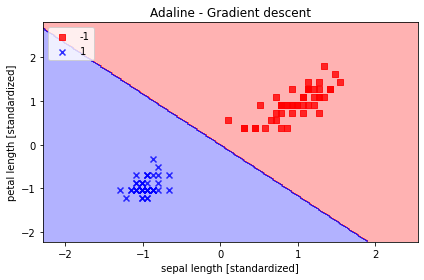

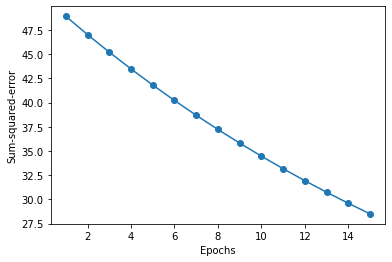

In [5]:
%run plot_decision_regions.py

ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title("Adaline - Gradient descent")
plt.xlabel("sepal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Sum-squared-error")
plt.show()

In [6]:
@dataclass
class AdalineSGD:
    eta: float = 0.01
    n_iter: int = 10
    shuffle: bool = True
    random_state: int = 1
    w_: list[float] = field(default_factory=list)
    w_initialized: bool = False
    cost_: list[float] = field(default_factory=list)

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = target - output
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

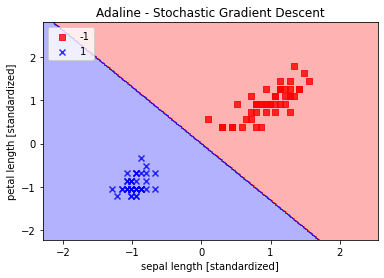

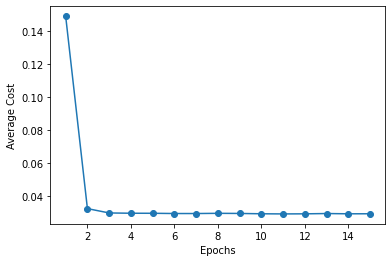

In [7]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title("Adaline - Stochastic Gradient Descent")
plt.xlabel("sepal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average Cost")
plt.show()